In [40]:
import pathlib
import urllib

import pandas as pd
from plotnine import *

# Outdated method

Computation method was the "naive" estimator described in https://arxiv.org/pdf/1605.07244.pdf.

Estimates are clearly far too high.

In [2]:
p_05_df = pd.read_csv('../p_0_5.tsv', sep='\t')

p_01_df = pd.read_csv('../p_0_1.tsv', sep='\t')

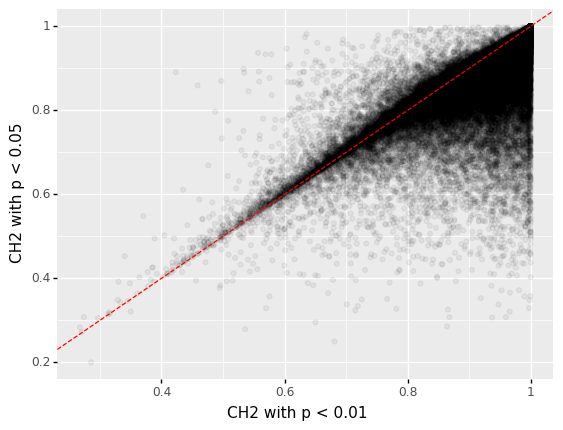

<ggplot: (317392520)>

In [11]:
plot_df = p_01_df.merge(p_05_df, on=['phenotype_x', 'phenotype_y'])

(
    ggplot(plot_df, aes(x='ch2_x', y='ch2_y')) +
    geom_point(alpha=0.05) +
    geom_abline(color='red', linetype='dashed') +
    xlab('CH2 with p < 0.01') +
    ylab('CH2 with p < 0.05')
)

# Load all ICD-10 UKBB phenotypes

In [39]:
phenotype_codes_df = pd.read_csv('../scripts/neale_aws_files.txt', header=None, names=['url'])

phenotype_codes_df.head(2)

,url
0,https://broad-ukb-sumstats-us-east-1.s3.amazon...
1,https://broad-ukb-sumstats-us-east-1.s3.amazon...


In [149]:
codes_df = (
    phenotype_codes_df
    .assign(
        file_name=lambda df: df['url'].apply(lambda x: pathlib.Path(urllib.parse.urlparse(x).path).name),
        code=lambda df: df['file_name'].apply(lambda x: x.split('.')[0])
    )
    .drop(columns=['url', 'file_name'])
)

codes_df.to_csv('../data/all_icd_codes.csv', index=False, header=False)

codes_df.head(2)

,code
0,A04
1,A08


# Apply heritability filters

1. Heritability estimate must have confidence > "none"
2. Phenotype must be "primary"

In [82]:
heritability_df = pd.read_csv('../ukb31063_h2_all.02Oct2019.tsv.gz', sep='\t', compression='gzip')

heritability_df.head(2)

/Users/zietzm/miniconda3/envs/qtp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,792) have mixed types.Specify dtype option on import or set low_memory=False.


,phenotype,sex,dilute,gwas_file,variable_type,n_missing,source,description,n,n_cases,...,isBadPower,isLowNeff,isMidNeff,isExtremeSE,isHighSE,isSexBias,isBadOrdinal,isNumericOrdinal,conf_simple,h2_sig
0,100001_irnt,both_sexes,NaN,100001_irnt.gwas.imputed_v3.both_sexes.tsv.bgz,continuous_irnt,309741,phesant,Food weight,51453,NaN,...,False,False,False,False,False,False,False,False,high,z4
1,100001_raw,both_sexes,NaN,100001_raw.gwas.imputed_v3.both_sexes.tsv.bgz,continuous_raw,309741,phesant,Food weight,51453,NaN,...,False,False,False,False,False,False,False,False,NaN,NaN


In [88]:
phenotype_heritability_df = (
    heritability_df
    .merge(codes_df, left_on='phenotype', right_on='code')
    .query('sex == "both_sexes"')
    .drop(columns=['code'])
)

phenotype_heritability_df.head(2)

,phenotype,sex,dilute,gwas_file,variable_type,n_missing,source,description,n,n_cases,...,isBadPower,isLowNeff,isMidNeff,isExtremeSE,isHighSE,isSexBias,isBadOrdinal,isNumericOrdinal,conf_simple,h2_sig
0,A04,both_sexes,NaN,A04.gwas.imputed_v3.both_sexes.tsv.bgz,binary,0,icd10,Diagnoses - main ICD10: A04 Other bacterial in...,361194,762.0,...,True,False,False,False,False,False,False,False,none,NaN
3,A08,both_sexes,NaN,A08.gwas.imputed_v3.both_sexes.tsv.bgz,binary,0,icd10,Diagnoses - main ICD10: A08 Viral and other sp...,361194,463.0,...,True,False,False,False,False,False,False,False,none,NaN


In [150]:
heritability_phenotypes_df = (
    phenotype_heritability_df
    .loc[:, ['phenotype', 'n_missing', 'n', 'n_cases', 'n_controls', 'h2_liability', 
             'h2_liability_se', 'h2_z', 'h2_p', 'isBinary', 'phen_stem', 'Neff', 'prevalence', 
             'keep', 'notes', 'confidence', 'conf_simple', 'isNotPrimary']]
    .query('(confidence != "none") & (isNotPrimary == False)')
)

heritability_phenotypes_df.head(2)

,phenotype,n_missing,n,n_cases,n_controls,h2_liability,h2_liability_se,h2_z,h2_p,isBinary,phen_stem,Neff,prevalence,keep,notes,confidence,conf_simple,isNotPrimary
6,A09,0,361194,2161.0,359033.0,-0.029687,0.043285,-0.685859,0.753599,True,A09,8592.28,0.005983,True,isLowNeff;,low,low,False
36,C18,0,361194,2226.0,358968.0,0.120329,0.042461,2.833887,0.002299,True,C18,8849.13,0.006163,True,isLowNeff;,low,low,False


# Apply genetic covariance filters

1. Only phenotypes that have all genetic covariances not NA.

In [2]:
ldsc_df = pd.read_csv('../geno_correlation.r2', sep='\s+')

ldsc_df.head(2)

,p1,p2,rg,se,z,p,h2_obs,h2_obs_se,h2_int,h2_int_se,gcov_int,gcov_int_se
0,../../results/UKbb/ldsc-additive-export/sumsta...,../../results/UKbb/ldsc-additive-export/sumsta...,0.9998,0.002135,468.400,0.000000e+00,0.06278,0.009665,1.006,0.006722,0.9886,0.006696
1,../../results/UKbb/ldsc-additive-export/sumsta...,../../results/UKbb/ldsc-additive-export/sumsta...,0.6925,0.091160,7.597,3.041000e-14,0.04259,0.009526,1.007,0.006756,0.5438,0.005280


In [72]:
ldsc_processed_df = (
    ldsc_df
    .filter(items=['p1', 'p2', 'rg', 'se', 'p'])
    .assign(
        p1=lambda df: df['p1'].apply(lambda x: pathlib.Path(x).name),
        p1_parts=lambda df: df['p1'].apply(lambda x: x.split('.')),
        p1_code=lambda df: df['p1_parts'].apply(lambda l: l[0]),
        p1_method=lambda df: df['p1_parts'].apply(lambda l: l[1]),
        p1_data=lambda df: df['p1_parts'].apply(lambda l: l[2]),
        p1_sex=lambda df: df['p1_parts'].apply(lambda l: l[3]),
        
        p2=lambda df: df['p2'].apply(lambda x: pathlib.Path(x).name),
        p2_parts=lambda df: df['p2'].apply(lambda x: x.split('.')),
        p2_code=lambda df: df['p2_parts'].apply(lambda l: l[0]),
        p2_method=lambda df: df['p2_parts'].apply(lambda l: l[1]),
        p2_data=lambda df: df['p2_parts'].apply(lambda l: l[2]),
        p2_sex=lambda df: df['p2_parts'].apply(lambda l: l[3]),
    )
    .query('(p1_method == "ldsc") & (p1_data == "imputed_v3") & (p1_sex == "both_sexes") & '
           '(p2_method == "ldsc") & (p2_data == "imputed_v3") & (p2_sex == "both_sexes")')
    .drop(columns=['p1_parts', 'p1_method', 'p1_data', 'p1_sex', 
                   'p2_parts', 'p2_method', 'p2_data', 'p2_sex'])
)

ldsc_processed_df.head(2)

,p1,p2,rg,se,p,p1_code,p2_code
0,100001_irnt.ldsc.imputed_v3.both_sexes.tsv.bgz,100001_raw.ldsc.imputed_v3.both_sexes.tsv.bgz,0.9998,0.002135,0.000000e+00,100001_irnt,100001_raw
1,100001_irnt.ldsc.imputed_v3.both_sexes.tsv.bgz,100002_irnt.ldsc.imputed_v3.both_sexes.tsv.bgz,0.6925,0.091160,3.041000e-14,100001_irnt,100002_irnt


In [103]:
list(phenotype_heritability_df.columns)

['phenotype',
 'sex',
 'dilute',
 'gwas_file',
 'variable_type',
 'n_missing',
 'source',
 'description',
 'n',
 'n_cases',
 'n_controls',
 'mean_chi2',
 'lambdaGC',
 'intercept',
 'intercept_se',
 'intercept_z',
 'intercept_p',
 'ratio',
 'ratio_se',
 'h2_observed',
 'h2_observed_se',
 'h2_liability',
 'h2_liability_se',
 'h2_z',
 'h2_p',
 'base..Prop_SNPs',
 'base..Prop_h2',
 'base..Prop_h2_se',
 'base..Enrichment',
 'base..Enrichment_se',
 'base..Enrichment_p',
 'base..Coefficient',
 'base..Coefficient_se',
 'base..Coefficient_z',
 'base..Coefficient_p',
 'Coding_UCSC..Prop_SNPs',
 'Coding_UCSC..Prop_h2',
 'Coding_UCSC..Prop_h2_se',
 'Coding_UCSC..Enrichment',
 'Coding_UCSC..Enrichment_se',
 'Coding_UCSC..Enrichment_p',
 'Coding_UCSC..Coefficient',
 'Coding_UCSC..Coefficient_se',
 'Coding_UCSC..Coefficient_z',
 'Coding_UCSC..Coefficient_p',
 'Coding_UCSC.extend.500..Prop_SNPs',
 'Coding_UCSC.extend.500..Prop_h2',
 'Coding_UCSC.extend.500..Prop_h2_se',
 'Coding_UCSC.extend.500..Enric

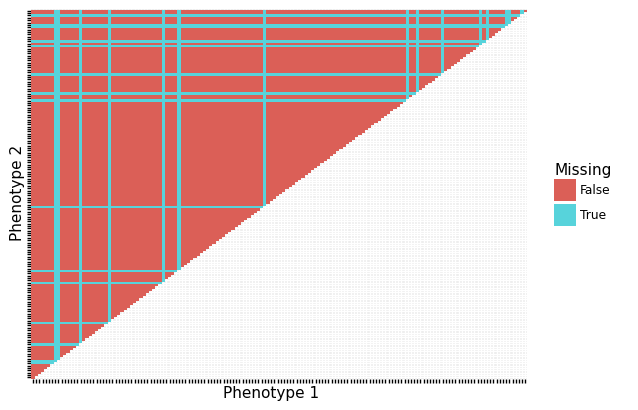

<ggplot: (412497942)>

In [151]:
plot_df = (
    ldsc_processed_df
    .merge(heritability_phenotypes_df['phenotype'], left_on='p1_code', right_on='phenotype')
    .merge(heritability_phenotypes_df['phenotype'], left_on='p2_code', right_on='phenotype')
    .drop(columns=['phenotype_x', 'phenotype_y'])
    .assign(fill=lambda df: df['rg'].isna())
)

(
    ggplot(plot_df, aes(x='p1_code', y='p2_code', fill='fill')) +
    geom_tile() +
    theme(axis_text = element_blank()) +
    xlab('Phenotype 1') +
    ylab('Phenotype 2') +
    scale_fill_discrete(name='Missing')
)

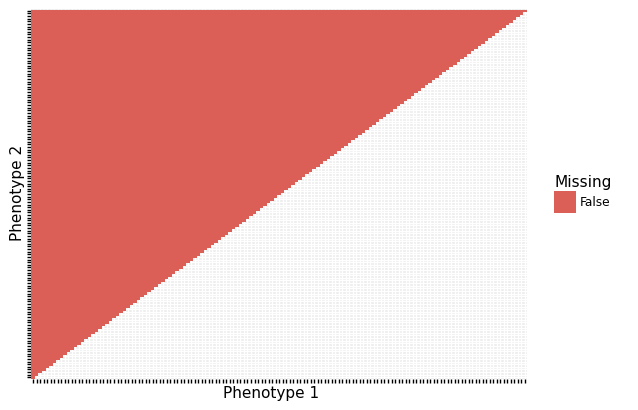

<ggplot: (368129311)>

In [152]:
plot_df = (
    ldsc_processed_df
    .merge(heritability_phenotypes_df['phenotype'], left_on='p1_code', right_on='phenotype')
    .merge(heritability_phenotypes_df['phenotype'], left_on='p2_code', right_on='phenotype')
    .drop(columns=['phenotype_x', 'phenotype_y'])
    .dropna()
    .assign(fill=lambda df: df['rg'].isna())
)

(
    ggplot(plot_df, aes(x='p1_code', y='p2_code', fill='fill')) +
    geom_tile() +
    theme(axis_text = element_blank()) +
    xlab('Phenotype 1') +
    ylab('Phenotype 2') +
    scale_fill_discrete(name='Missing')
)

# Final phenotype list

In [157]:
phenotypes_to_use = sorted(set(
    ldsc_processed_df
    .merge(heritability_phenotypes_df['phenotype'], left_on='p1_code', right_on='phenotype')
    .merge(heritability_phenotypes_df['phenotype'], left_on='p2_code', right_on='phenotype')
    .dropna()
    .loc[:, ['phenotype_x', 'phenotype_y']]
    .values
    .flatten()
))

print(len(phenotypes_to_use))

phenotypes_to_use[:4]

142


['A09', 'C18', 'C34', 'C43']

In [159]:
with open('../data/chosen_icd_codes.csv', 'w') as f:
    f.writelines([p + '\n' for p in phenotypes_to_use])